In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers, models
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# CNN + SVM

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 30

 # Standardize image size
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [3]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in Pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(Pre_trained_model.layers))

Metal device set to: Apple M1


2023-02-14 10:02:23.816404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 10:02:23.816913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [4]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [134]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)

# Configure and compile the model

model = Model(Pre_trained_model.input, x)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

# Use VGG16 as feature extraction tool and then pass the output of pretrained model as input
# Argue that you improve Random Forest Classifier - pass better features to classifier so it improves
# Get features out of VGG16 and then pass them to Random Forest Classifier

In [135]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [136]:
#Training the MODEL Feature-Extraction
#If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of 
# feature extraction first so that weights of the final fully connected layer aren't completely random. 
#The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large
#and will change the pretrained weights too much.
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# We only train 5 EPOCHS 
epochs = 10
batch_size = 30

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10


2023-02-14 10:36:11.168464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.8250 - acc: 0.5633

2023-02-14 10:36:17.127778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 768ms/step - loss: 0.8250 - acc: 0.5633 - val_loss: 0.5459 - val_acc: 0.7111
Epoch 2/10
10/10 [==============================] - 7s 708ms/step - loss: 0.6021 - acc: 0.6600 - val_loss: 0.5664 - val_acc: 0.7333
Epoch 3/10
10/10 [==============================] - 7s 703ms/step - loss: 0.5440 - acc: 0.7033 - val_loss: 0.6824 - val_acc: 0.5333
Epoch 4/10
10/10 [==============================] - 7s 703ms/step - loss: 0.4989 - acc: 0.7633 - val_loss: 0.4928 - val_acc: 0.7333
Epoch 5/10
10/10 [==============================] - 7s 703ms/step - loss: 0.4892 - acc: 0.7467 - val_loss: 0.5726 - val_acc: 0.6556
Epoch 6/10
10/10 [==============================] - 7s 702ms/step - loss: 0.4579 - acc: 0.7567 - val_loss: 0.5350 - val_acc: 0.7333
Epoch 7/10
10/10 [==============================] - 7s 704ms/step - loss: 0.4246 - acc: 0.7967 - val_loss: 0.6139 - val_acc: 0.6444
Epoch 8/10
10/10 [==============================] - 7s 703ms/step - loss: 0.4156 - acc:

In [137]:
acc = r.history['acc']
val_acc = r.history['val_acc']

loss = r.history['loss']
val_loss = r.history['val_loss']

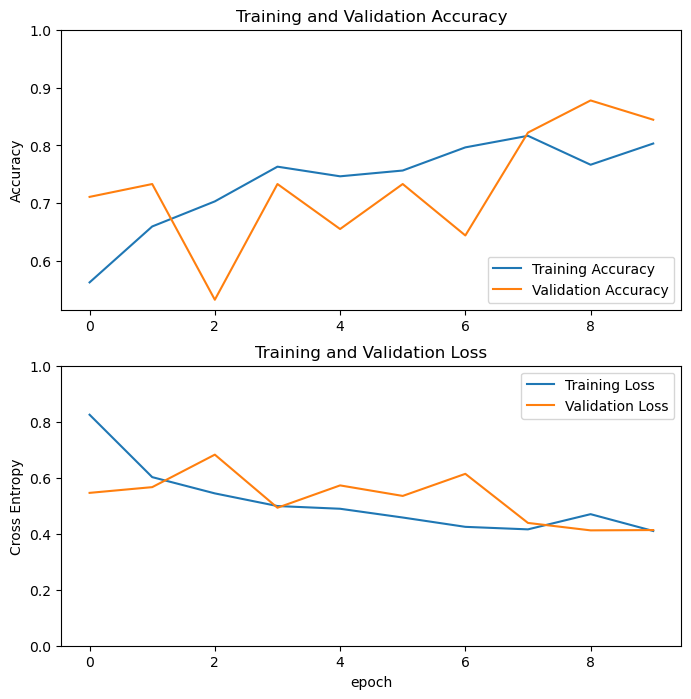

In [138]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [139]:
model2 = Sequential()
for layer in model.layers[:-1]:
    model2.add(layer)

In [140]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)     

In [141]:
# training data for SVM Classifier
X_train, y_train = next(train_generator)
for i in range((300//batch_size) - 1):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(300, 224, 224, 3) (300, 2)


In [142]:
# validation data for SVM Classifier
X_valid, y_valid = next(validation_generator)
for i in range((100//batch_size) - 1):
    img, label = next(validation_generator)
    X_valid = np.append(X_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)
print(X_valid.shape, y_valid.shape)

(70, 224, 224, 3) (70, 2)


In [143]:
feature_mapping = model2(X_train)

In [144]:
clf = svm.SVC()
clf.fit(feature_mapping, y_train.argmax(axis=1))

SVC()

In [145]:
features = model2.predict(X_valid)

1/3 [=========>....................] - ETA: 0s

2023-02-14 10:37:35.026689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 528ms/step


In [146]:
predictionSVM = clf.predict(features)

Accuracy = 0.8
Recall = 0.7777777777777778
Precision = 0.8235294117647058


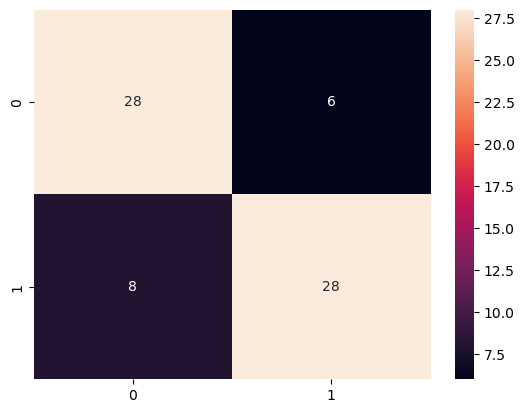

In [147]:
cm = confusion_matrix(y_valid.argmax(axis=1), predictionSVM)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM))
print("Recall =", recall)
print("Precision =", precision)

# Simple SVM

In [97]:
# Reshape images to pass into SVM
lenofimageT = len(X_train)
lenofimageV = len(X_valid)
X_train2 = np.array(X_train).reshape(lenofimageT, -1)
X_valid2 = np.array(X_valid).reshape(lenofimageV, -1)
y_train2 = y_train.argmax(axis=1)
y_valid2 = y_valid.argmax(axis=1)

In [98]:
clf2 = svm.SVC()

In [99]:
clf2.fit(X_train2, y_train2)

SVC()

In [100]:
predictionSVM2 = clf2.predict(X_valid2)

Accuracy = 0.6666666666666666
Recall = 0.7777777777777778
Precision = 0.6222222222222222


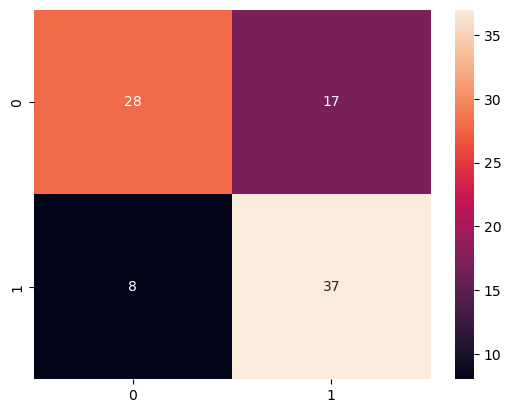

In [101]:
cm = confusion_matrix(y_valid2, predictionSVM2)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()


tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM))
print("Recall =", recall)
print("Precision =", precision)